# UROP

## DESIRE: Distant Future Prediction in Dynamic Scenes with Interacting Agents

[CVPR Paper](https://arxiv.org/pdf/1704.04394.pdf)

[Supplementary Notes](http://www.robots.ox.ac.uk/~namhoon/doc/DESIRE-supp.pdf)

# Sample Generation Module

## TODO:

1) Synchronised batch

2) Put everything into one big model

3) Save and load model

4) Train/test flag
  * Train has output Y_hat and z
  * Test has input z array and output Y_hat
  
5) Visualise loss

In [1]:
import csv
import numpy as np
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter

torch.backends.cudnn.enabled = False

## Data

In [2]:
def print_line_sep():
    print('--------------------------------------')

In [3]:
raw_data = []
with open('raw_data/raw_record.csv', 'r') as csvfile:
    csvreader = csv.reader(csvfile)
    raw_data = list(csvreader)
print('Raw data extract:')
print(raw_data[0])
print_line_sep()

filtered_data = [[int(row[0]), int(row[1]), float(row[2]), float(row[3])] for row in raw_data]
print('Filtered data extract:')
print(filtered_data[0])
print_line_sep()

dict_data = {}
for row in filtered_data:
    time = row[0]
    car = row[1]
    x = row[2]
    y = row[3]
    
    if car in dict_data:
        dict_data[car].append([time, x, y])
    else:
        dict_data[car] = [[time, x, y]]
print('Data dictionary extract:')
print(dict_data[172][0])

Raw data extract:
['1', '172', '93.939', '-55.7615', '0', '-3.0066', '5.27149', '4', '10']
--------------------------------------
Filtered data extract:
[1, 172, 93.939, -55.7615]
--------------------------------------
Data dictionary extract:
[1, 93.939, -55.7615]


In [4]:
def get_random_batches(x_seq_len, y_seq_len, batch_size):
    batches = []
    dict_data_keys = list(dict_data.keys())
    
    while(len(batches) < batch_size): # Fill up batches with batch_size rows of x+y_seq_len columns
        car = random.choice(dict_data_keys)
        batch = []
        is_first = True
        
        # Loop through each row of that car until x+y_seq_len columns are found
        for row in dict_data[car]:
            time = row[0]
            x = row[1]
            y = row[2]
            
            # If first item of the sequence, just append
            if is_first:
                batch.append([time, x, y])
                is_first = False
                
            # If not, check if time diff is 1
            else:
                prev_time = batch[-1][0]
                
                # If time diff is not 1,
                # 1) Clear batch item
                # 2) Start from current location as first batch item
                if time - prev_time != 1:
                    batch = []
                    batch.append([time, x, y])
                    
                # Otherwise, just append to batch item
                else:
                    batch.append([time, x, y])
            
            # If batch item columns are enough, break
            if len(batch) == x_seq_len + y_seq_len:
                batches.append(batch)
                break
                
    # Just keep (x,y)  
    X_position_array = [[[item[1], item[2]] for item in batch[:x_seq_len]] for batch in batches]
    Y_position_array = [[[item[1], item[2]] for item in batch[x_seq_len:]] for batch in batches]
    
    X_position_np = np.asarray(X_position_array).transpose(0, 2, 1)
    Y_position_np = np.asarray(Y_position_array).transpose(0, 2, 1)
    
    X_position_tensor = Variable(torch.from_numpy(X_position_np).type(torch.FloatTensor)).cuda()
    Y_position_tensor = Variable(torch.from_numpy(Y_position_np).type(torch.FloatTensor)).cuda()
    
    # Convert position to displacement
    X_displacement_array = []
    Y_displacement_array = []

    for i in range(batch_size):
        x_first = X_position_array[i][0][0]
        y_first = X_position_array[i][0][1]

        X_batch = X_position_array[i]
        X_displacement_array.append([[item[0] - x_first, item[1] - y_first] for item in X_batch])

        Y_batch = Y_position_array[i]
        Y_displacement_array.append([[item[0] - x_first, item[1] - y_first] for item in Y_batch])

    X_displacement_np = np.asarray(X_displacement_array).transpose(0, 2, 1)    
    Y_displacement_np = np.asarray(Y_displacement_array).transpose(0, 2, 1)
    
    X_displacement_tensor = Variable(torch.from_numpy(X_displacement_np).type(torch.FloatTensor)).cuda()
    Y_displacement_tensor = Variable(torch.from_numpy(Y_displacement_np).type(torch.FloatTensor)).cuda()
    
    return X_position_tensor, Y_position_tensor, X_displacement_tensor, Y_displacement_tensor

In [5]:
X_position_test, Y_position_test, X_displacement_test, Y_displacement_test = get_random_batches(20, 40, 8)

print('X positions:')
print(X_position_test.size())
print(X_position_test[0])

print_line_sep()

print('Y positions:')
print(Y_position_test.size())
print(Y_position_test[0])

print_line_sep()

print('X displacements:')
print(X_displacement_test.size())
print(X_displacement_test[0])

print_line_sep()

print('Y displacements:')
print(Y_displacement_test.size())
print(Y_displacement_test[0])

X positions:
torch.Size([8, 2, 20])
tensor([[ 338.7340,  338.7340,  338.7340,  338.7340,  338.7340,  338.7340,
          338.7340,  338.7340,  338.7340,  338.7340,  338.7340,  338.7340,
          338.7340,  338.7340,  338.7340,  338.7340,  338.7340,  338.7340,
          338.7340,  338.7340],
        [-122.2890, -122.2890, -122.2890, -122.2890, -122.2890, -122.2890,
         -122.2890, -122.2890, -122.2890, -122.2890, -122.2890, -122.2890,
         -122.2890, -122.2890, -122.2890, -122.2890, -122.2890, -122.2890,
         -122.2890, -122.2890]], device='cuda:0')
--------------------------------------
Y positions:
torch.Size([8, 2, 40])
tensor([[ 338.7340,  338.7340,  338.7340,  338.7340,  338.7340,  338.7340,
          338.7340,  338.7340,  338.7340,  338.7340,  338.7340,  338.7340,
          338.7340,  338.7340,  338.7340,  338.7340,  338.7340,  338.7340,
          338.7340,  338.7340,  338.7340,  338.7340,  338.7340,  338.7340,
          338.7340,  338.7340,  338.7340,  338.7340,  338

## Model

### Encoder

In [6]:
class SampleEncoder(nn.Module):
    def __init__(self,
                 input_dim, seq_len, num_layers,
                 conv_output_dim, conv_kernel_size,
                 gru_hidden_dim):
        super(SampleEncoder, self).__init__()
        
        self.seq_len = seq_len
        self.num_layers = num_layers
        self.conv_output_dim = conv_output_dim
        self.conv_kernel_size = conv_kernel_size
        self.gru_hidden_dim = gru_hidden_dim
        
        # C = X or Y
        # C_i, (input_dim, seq_len) -> tC_i, (conv_output_dim, seq_len)
        self.conv = nn.Conv1d(input_dim, conv_output_dim, conv_kernel_size)

        # tC_i, (conv_output_dim, seq_len) -> H_C_i, (gru_hidden_dim)
        self.gru = nn.GRU(conv_output_dim, gru_hidden_dim, num_layers)

    def init_hidden(self, batch_size):
        # Initial hidden vector is hidden_dim-dimensional and padded with 0
        return Variable(torch.zeros(self.num_layers, batch_size, self.gru_hidden_dim)).cuda()

    def forward(self, x, hidden):
        batch_size = x.size(0)
        
        conv_output = self.conv(x)
        conv_output = F.relu(conv_output)
        
        # conv_output has dimensions (batch_size, dim, seq_len)
        # GRU accepts input tensor with dimensions (seq_len, batch_size, dim)
        # TODO: Pad
        conv_output = conv_output.permute(2, 0, 1)
        
        output, hidden = self.gru(conv_output, hidden)
        
        return output, hidden

### Conditional Variational Auto Encoder

In [7]:
class SampleCVAE(nn.Module):
    def __init__(self, input_dim, output_dim, mu_dim, sigma_dim):
        super(SampleCVAE, self).__init__()
        
        self.sigma_dim = sigma_dim

        self.fc1 = nn.Linear(input_dim, output_dim)
        self.fc_mu = nn.Linear(output_dim, mu_dim)
        self.fc_sigma = nn.Linear(output_dim, sigma_dim)

    def forward(self, x):
        batch_size = x.size(0)
        
        output = self.fc1(x)
        output = F.relu(output)
        
        mu = self.fc_mu(output)
        sigma = torch.div(torch.exp(self.fc_sigma(output)), 2)
        epsilon = Variable(torch.normal(torch.zeros(batch_size, self.sigma_dim),
                           torch.ones(batch_size, self.sigma_dim))).cuda()
        # Reparam trick
        z = mu + sigma*epsilon

        return z

### Fully Connected Softmax Layer

In [8]:
class SampleFCS(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SampleFCS, self).__init__()
        
        self.fcs = nn.Linear(input_dim, output_dim)
        
    def forward(self, x):
        output = self.fcs(x)
        output = F.log_softmax(output, dim=2)
        return output

### Decoder

In [9]:
class SampleDecoder(nn.Module):
    def __init__(self, input_dim, seq_len, num_layers, gru_hidden_dim, gru_output_dim, output_dim):
        super(SampleDecoder, self).__init__()
        
        self.seq_len = seq_len
        self.num_layers = num_layers
        self.gru_hidden_dim = gru_hidden_dim
        
        self.gru = nn.GRU(input_dim, gru_output_dim, num_layers)
        self.linear = nn.Linear(gru_output_dim, output_dim)
        
    def init_hidden(self, batch_size):
        return Variable(torch.zeros(self.num_layers, batch_size, self.gru_hidden_dim)).cuda()
        
    def forward(self, x, hidden):
        output, hidden = self.gru(x, hidden)
        output = self.linear(output)
        return output, hidden

## Train

In [10]:
# Hyperparameters
learning_rate = 0.0001
num_epochs = 1000
batch_size = 8
X_seq_len = 20
Y_seq_len = 40

In [11]:
# Initialize model

# input_dim = 2        | input is a sequence of (x,y) coordinates (i.e. 2-dimensional)
# seq_len = 20         | time sequence length of 20
# conv_output_dim = 16 | 1D convolution with 16 output channels
# conv_kernel_size = 3 | 1D convolution with kernel of width 3
# gru_hidden_dim = 48  | 48-dimensional hidden vector
#
# Input: Tensor of size (batch_size, 2, 20)
encoder1 = SampleEncoder(input_dim=2, seq_len=X_seq_len, num_layers=1,
                         conv_output_dim=16, conv_kernel_size=3,
                         gru_hidden_dim=48).cuda()

# input_dim = 2        | input is a sequence of (x,y) coordinates (i.e. 2-dimensional)
# seq_len = 40         | time sequence length of 40
# conv_output_dim = 16 | 1D convolution with 16 output channels
# conv_kernel_size = 1 | 1D convolution with kernel of width 1
# gru_hidden_dim = 48  | 48-dimensional hidden vector
#
# Input: Tensor of size (batch_size, 2, 40)
encoder2 = SampleEncoder(input_dim=2, seq_len=Y_seq_len, num_layers=1,
                         conv_output_dim=16, conv_kernel_size=1,
                         gru_hidden_dim=48).cuda()

# input_dim = 96       | Concatenate encoder1's and encoder2's outputs (48-dim each) into 1 output (96-dim)
# output_dim = 48      | Transform concatenated 96-dim vector into 48-dim vector
# mu_dim = 48          | mu is 48-dim
# sigma_dim = 48       | sigma is 48-dim
#
# Input: Tensor of size (batch_size, 48)
cvae = SampleCVAE(input_dim=96, output_dim=48, mu_dim=48, sigma_dim=48).cuda()

# input_dim = 48       |
# output_dim = 48      |
#
# Input: Tensor of size (batch_size, 48)
fcs = SampleFCS(input_dim=48, output_dim=48).cuda()

# input_dim = 48       |
# seq_len = 40         | time sequence length of 40
# gru_hidden_dim = 48  |
# gru_output_dim = 48  |
# output_dim = 2       |
#
# Input: Tensor of size (40, batch_size, 48)
decoder1 = SampleDecoder(input_dim=48, seq_len=40, num_layers=1,
                        gru_hidden_dim=48, gru_output_dim=48,
                        output_dim=2).cuda()

# Loss
kld = nn.KLDivLoss()
mse = nn.MSELoss()

# Optimizer
# optimizer = optim.Adam([
#     {'params': encoder1.parameters()},
#     {'params': encoder2.parameters()},
#     {'params': cvae.parameters()},
#     {'params': fcs.parameters()},
#     {'params': decoder1.parameters()}
# ], lr=learning_rate
# )

encoder1_optimizer = optim.Adam(encoder1.parameters(), lr=learning_rate)
encoder2_optimizer = optim.Adam(encoder2.parameters(), lr=learning_rate)
cvae_optimizer = optim.Adam(cvae.parameters(), lr=learning_rate)
fcs_optimizer = optim.Adam(fcs.parameters(), lr=learning_rate)
decoder1_optimizer = optim.Adam(decoder1.parameters(), lr=learning_rate)

(Epoch 1) Total Loss: 11.394, KLD Loss: 1.435, MSE Loss: 9.958
(Epoch 2) Total Loss: 20.080, KLD Loss: 1.625, MSE Loss: 18.456
(Epoch 3) Total Loss: 30.731, KLD Loss: 1.729, MSE Loss: 29.002
(Epoch 4) Total Loss: 24.669, KLD Loss: 1.751, MSE Loss: 22.918
(Epoch 5) Total Loss: 20.341, KLD Loss: 1.578, MSE Loss: 18.763
(Epoch 6) Total Loss: 70.963, KLD Loss: 1.601, MSE Loss: 69.362
(Epoch 7) Total Loss: 42.458, KLD Loss: 1.541, MSE Loss: 40.917
(Epoch 8) Total Loss: 15.113, KLD Loss: 1.439, MSE Loss: 13.675
(Epoch 9) Total Loss: 11.877, KLD Loss: 1.855, MSE Loss: 10.022
(Epoch 10) Total Loss: 17.075, KLD Loss: 1.581, MSE Loss: 15.494
(Epoch 11) Total Loss: 24.998, KLD Loss: 1.456, MSE Loss: 23.542
(Epoch 12) Total Loss: 17.905, KLD Loss: 1.478, MSE Loss: 16.427
(Epoch 13) Total Loss: 22.676, KLD Loss: 1.680, MSE Loss: 20.997
(Epoch 14) Total Loss: 44.887, KLD Loss: 1.680, MSE Loss: 43.207
(Epoch 15) Total Loss: 23.855, KLD Loss: 1.443, MSE Loss: 22.411
(Epoch 16) Total Loss: 27.043, KLD 

(Epoch 128) Total Loss: 30.328, KLD Loss: 1.382, MSE Loss: 28.946
(Epoch 129) Total Loss: 16.147, KLD Loss: 1.610, MSE Loss: 14.536
(Epoch 130) Total Loss: 17.082, KLD Loss: 1.665, MSE Loss: 15.417
(Epoch 131) Total Loss: 21.350, KLD Loss: 1.896, MSE Loss: 19.454
(Epoch 132) Total Loss: 13.987, KLD Loss: 1.611, MSE Loss: 12.376
(Epoch 133) Total Loss: 14.064, KLD Loss: 1.488, MSE Loss: 12.576
(Epoch 134) Total Loss: 10.516, KLD Loss: 1.662, MSE Loss: 8.855
(Epoch 135) Total Loss: 12.691, KLD Loss: 1.549, MSE Loss: 11.142
(Epoch 136) Total Loss: 7.202, KLD Loss: 1.678, MSE Loss: 5.523
(Epoch 137) Total Loss: 15.622, KLD Loss: 1.703, MSE Loss: 13.919
(Epoch 138) Total Loss: 24.629, KLD Loss: 1.669, MSE Loss: 22.960
(Epoch 139) Total Loss: 16.619, KLD Loss: 1.384, MSE Loss: 15.235
(Epoch 140) Total Loss: 22.549, KLD Loss: 1.640, MSE Loss: 20.909
(Epoch 141) Total Loss: 14.130, KLD Loss: 1.425, MSE Loss: 12.704
(Epoch 142) Total Loss: 12.428, KLD Loss: 1.604, MSE Loss: 10.824
(Epoch 143) T

(Epoch 257) Total Loss: 7.571, KLD Loss: 1.867, MSE Loss: 5.704
(Epoch 258) Total Loss: 8.880, KLD Loss: 1.763, MSE Loss: 7.117
(Epoch 259) Total Loss: 6.696, KLD Loss: 1.645, MSE Loss: 5.050
(Epoch 260) Total Loss: 5.066, KLD Loss: 1.606, MSE Loss: 3.461
(Epoch 261) Total Loss: 9.064, KLD Loss: 1.690, MSE Loss: 7.374
(Epoch 262) Total Loss: 8.300, KLD Loss: 1.685, MSE Loss: 6.615
(Epoch 263) Total Loss: 6.605, KLD Loss: 1.543, MSE Loss: 5.061
(Epoch 264) Total Loss: 9.472, KLD Loss: 1.425, MSE Loss: 8.046
(Epoch 265) Total Loss: 11.028, KLD Loss: 1.482, MSE Loss: 9.545
(Epoch 266) Total Loss: 6.021, KLD Loss: 1.708, MSE Loss: 4.313
(Epoch 267) Total Loss: 7.452, KLD Loss: 1.635, MSE Loss: 5.817
(Epoch 268) Total Loss: 12.030, KLD Loss: 1.718, MSE Loss: 10.312
(Epoch 269) Total Loss: 22.310, KLD Loss: 1.602, MSE Loss: 20.708
(Epoch 270) Total Loss: 22.926, KLD Loss: 1.260, MSE Loss: 21.666
(Epoch 271) Total Loss: 7.043, KLD Loss: 1.778, MSE Loss: 5.266
(Epoch 272) Total Loss: 21.507, K

(Epoch 389) Total Loss: 11.664, KLD Loss: 1.548, MSE Loss: 10.116
(Epoch 390) Total Loss: 6.301, KLD Loss: 1.538, MSE Loss: 4.763
(Epoch 391) Total Loss: 8.360, KLD Loss: 1.683, MSE Loss: 6.677
(Epoch 392) Total Loss: 6.747, KLD Loss: 1.582, MSE Loss: 5.165
(Epoch 393) Total Loss: 6.917, KLD Loss: 1.671, MSE Loss: 5.246
(Epoch 394) Total Loss: 5.077, KLD Loss: 1.820, MSE Loss: 3.257
(Epoch 395) Total Loss: 10.036, KLD Loss: 1.739, MSE Loss: 8.297
(Epoch 396) Total Loss: 5.430, KLD Loss: 1.697, MSE Loss: 3.733
(Epoch 397) Total Loss: 5.799, KLD Loss: 1.519, MSE Loss: 4.280
(Epoch 398) Total Loss: 6.581, KLD Loss: 1.616, MSE Loss: 4.965
(Epoch 399) Total Loss: 5.111, KLD Loss: 1.848, MSE Loss: 3.263
(Epoch 400) Total Loss: 11.884, KLD Loss: 1.737, MSE Loss: 10.147
(Epoch 401) Total Loss: 7.778, KLD Loss: 1.733, MSE Loss: 6.045
(Epoch 402) Total Loss: 6.380, KLD Loss: 1.616, MSE Loss: 4.764
(Epoch 403) Total Loss: 8.918, KLD Loss: 1.656, MSE Loss: 7.262
(Epoch 404) Total Loss: 8.463, KLD 

(Epoch 521) Total Loss: 7.115, KLD Loss: 1.711, MSE Loss: 5.404
(Epoch 522) Total Loss: 4.840, KLD Loss: 1.447, MSE Loss: 3.393
(Epoch 523) Total Loss: 3.884, KLD Loss: 1.468, MSE Loss: 2.416
(Epoch 524) Total Loss: 7.052, KLD Loss: 1.981, MSE Loss: 5.071
(Epoch 525) Total Loss: 5.239, KLD Loss: 1.815, MSE Loss: 3.424
(Epoch 526) Total Loss: 3.407, KLD Loss: 1.556, MSE Loss: 1.852
(Epoch 527) Total Loss: 5.747, KLD Loss: 1.730, MSE Loss: 4.017
(Epoch 528) Total Loss: 18.105, KLD Loss: 1.659, MSE Loss: 16.446
(Epoch 529) Total Loss: 8.186, KLD Loss: 1.591, MSE Loss: 6.595
(Epoch 530) Total Loss: 7.096, KLD Loss: 1.716, MSE Loss: 5.380
(Epoch 531) Total Loss: 8.998, KLD Loss: 2.004, MSE Loss: 6.994
(Epoch 532) Total Loss: 16.184, KLD Loss: 1.619, MSE Loss: 14.565
(Epoch 533) Total Loss: 15.221, KLD Loss: 1.678, MSE Loss: 13.543
(Epoch 534) Total Loss: 7.503, KLD Loss: 1.547, MSE Loss: 5.955
(Epoch 535) Total Loss: 4.616, KLD Loss: 1.565, MSE Loss: 3.051
(Epoch 536) Total Loss: 4.040, KLD

(Epoch 652) Total Loss: 7.722, KLD Loss: 1.977, MSE Loss: 5.745
(Epoch 653) Total Loss: 5.833, KLD Loss: 1.482, MSE Loss: 4.351
(Epoch 654) Total Loss: 3.898, KLD Loss: 1.560, MSE Loss: 2.338
(Epoch 655) Total Loss: 18.399, KLD Loss: 1.720, MSE Loss: 16.678
(Epoch 656) Total Loss: 2.803, KLD Loss: 1.464, MSE Loss: 1.339
(Epoch 657) Total Loss: 7.959, KLD Loss: 1.575, MSE Loss: 6.384
(Epoch 658) Total Loss: 16.917, KLD Loss: 1.458, MSE Loss: 15.459
(Epoch 659) Total Loss: 5.725, KLD Loss: 1.723, MSE Loss: 4.002
(Epoch 660) Total Loss: 4.510, KLD Loss: 1.720, MSE Loss: 2.791
(Epoch 661) Total Loss: 2.061, KLD Loss: 1.623, MSE Loss: 0.438
(Epoch 662) Total Loss: 3.131, KLD Loss: 1.432, MSE Loss: 1.699
(Epoch 663) Total Loss: 5.488, KLD Loss: 1.770, MSE Loss: 3.718
(Epoch 664) Total Loss: 14.609, KLD Loss: 1.676, MSE Loss: 12.933
(Epoch 665) Total Loss: 5.518, KLD Loss: 1.866, MSE Loss: 3.652
(Epoch 666) Total Loss: 6.314, KLD Loss: 1.597, MSE Loss: 4.716
(Epoch 667) Total Loss: 6.563, KLD

(Epoch 782) Total Loss: 4.164, KLD Loss: 1.656, MSE Loss: 2.508
(Epoch 783) Total Loss: 6.549, KLD Loss: 1.602, MSE Loss: 4.946
(Epoch 784) Total Loss: 4.894, KLD Loss: 1.418, MSE Loss: 3.476
(Epoch 785) Total Loss: 8.073, KLD Loss: 1.971, MSE Loss: 6.103
(Epoch 786) Total Loss: 3.879, KLD Loss: 1.710, MSE Loss: 2.169
(Epoch 787) Total Loss: 4.774, KLD Loss: 1.356, MSE Loss: 3.417
(Epoch 788) Total Loss: 6.671, KLD Loss: 1.678, MSE Loss: 4.993
(Epoch 789) Total Loss: 5.196, KLD Loss: 1.687, MSE Loss: 3.508
(Epoch 790) Total Loss: 4.774, KLD Loss: 1.751, MSE Loss: 3.023
(Epoch 791) Total Loss: 9.436, KLD Loss: 1.524, MSE Loss: 7.913
(Epoch 792) Total Loss: 4.964, KLD Loss: 1.637, MSE Loss: 3.327
(Epoch 793) Total Loss: 4.723, KLD Loss: 1.684, MSE Loss: 3.039
(Epoch 794) Total Loss: 5.795, KLD Loss: 1.862, MSE Loss: 3.933
(Epoch 795) Total Loss: 5.362, KLD Loss: 1.710, MSE Loss: 3.652
(Epoch 796) Total Loss: 4.389, KLD Loss: 2.055, MSE Loss: 2.335
(Epoch 797) Total Loss: 4.482, KLD Loss:

(Epoch 914) Total Loss: 8.126, KLD Loss: 1.623, MSE Loss: 6.502
(Epoch 915) Total Loss: 8.680, KLD Loss: 1.901, MSE Loss: 6.779
(Epoch 916) Total Loss: 4.130, KLD Loss: 1.589, MSE Loss: 2.541
(Epoch 917) Total Loss: 4.524, KLD Loss: 1.689, MSE Loss: 2.835
(Epoch 918) Total Loss: 3.695, KLD Loss: 1.670, MSE Loss: 2.026
(Epoch 919) Total Loss: 4.053, KLD Loss: 1.454, MSE Loss: 2.599
(Epoch 920) Total Loss: 4.430, KLD Loss: 1.791, MSE Loss: 2.639
(Epoch 921) Total Loss: 5.059, KLD Loss: 1.561, MSE Loss: 3.498
(Epoch 922) Total Loss: 6.520, KLD Loss: 1.467, MSE Loss: 5.053
(Epoch 923) Total Loss: 5.201, KLD Loss: 1.590, MSE Loss: 3.611
(Epoch 924) Total Loss: 3.530, KLD Loss: 1.571, MSE Loss: 1.959
(Epoch 925) Total Loss: 4.758, KLD Loss: 1.551, MSE Loss: 3.206
(Epoch 926) Total Loss: 4.724, KLD Loss: 2.026, MSE Loss: 2.697
(Epoch 927) Total Loss: 8.108, KLD Loss: 1.867, MSE Loss: 6.241
(Epoch 928) Total Loss: 5.150, KLD Loss: 1.649, MSE Loss: 3.501
(Epoch 929) Total Loss: 6.751, KLD Loss:

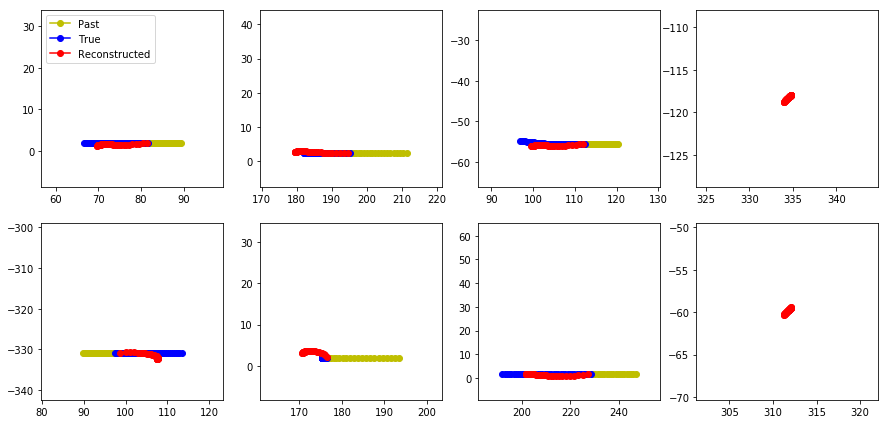

In [12]:
# writer = SummaryWriter()

for epoch in range(num_epochs):
    X_position, Y_position, X_displacement, Y_displacement = get_random_batches(X_seq_len, Y_seq_len, batch_size)
    
#     writer.add_scalars('data/X', {
#         'x': X.permute(0, 2, 1)[0][0][0],
#         'y': Y.permute(0, 2, 1)[0][0][0]
#     }, epoch)
    
    running_kld_loss = 0.0
    running_mse_loss = 0.0
    running_loss = 0.0
    
#     optimizer.zero_grad()
    encoder1_optimizer.zero_grad()
    encoder2_optimizer.zero_grad()
    cvae_optimizer.zero_grad()
    fcs_optimizer.zero_grad()
    decoder1_optimizer.zero_grad()
    
    # Encoder 1
    e1_hidden = encoder1.init_hidden(batch_size)
    e1_output, e1_last_hidden = encoder1(X_displacement, e1_hidden)
    H_X = e1_last_hidden

    # Encoder 2
    e2_hidden = encoder2.init_hidden(batch_size)
    e2_output, e2_last_hidden = encoder2(Y_displacement, e2_hidden)
    H_Y = e2_last_hidden

    # CVAE
    H_XY = torch.cat([H_X, H_Y], 2)
    z = cvae(H_XY)

    # FCS
    beta_z = fcs(z)
    
    # Decoder
    xz = H_X*beta_z
    hxz = xz
    for i in range(39):
        hxz = torch.cat((hxz, Variable(torch.zeros(1, batch_size, 48)).cuda()), 0)
    decoder_hidden = decoder1.init_hidden(batch_size)
    output, last_hidden = decoder1(hxz, decoder_hidden)

    # Reconstruction
    X0 = X_position.permute(2, 0, 1)[-1]
    delta_X0 = output[0]    
    Y0_hat = X0 + delta_X0
    Y_hat = Y0_hat.unsqueeze(0)
    
    for i in range(1, Y_seq_len):
        Yi = Y_hat[i - 1]
        delta_Xi = output[i]
        Yi_hat = Yi + delta_Xi
        Yi_hat = Yi_hat.unsqueeze(0)
        Y_hat = torch.cat((Y_hat, Yi_hat), 0)
    #Y_hat = Y_hat.permute(1, 2, 0)
        
    # Minimise loss
    # KLD Loss requires random z in N(0,1)
    test_z = Variable(torch.normal(torch.zeros(batch_size, 48),
                                   torch.ones(batch_size, 48))).cuda()
    test_z = test_z.unsqueeze(0)
    kld_loss = kld(beta_z, test_z)
    
    # MSE Loss requires to add displacement at all steps before
    Y_true = Y_position.permute(2, 0, 1)
    mse_loss = mse(Y_hat, Y_true)
    
    # Combine losses
    loss = kld_loss + mse_loss
    loss.backward()

#     optimizer.step()
    encoder1_optimizer.step()
    encoder2_optimizer.step()
    cvae_optimizer.step()
    fcs_optimizer.step()
    decoder1_optimizer.step()
    
    running_kld_loss += kld_loss.item()
    running_mse_loss += mse_loss.item()
    running_loss += loss.item()
    print('(Epoch %d) Total Loss: %.3f, KLD Loss: %.3f, MSE Loss: %.3f' 
          % (epoch + 1, running_loss, running_kld_loss, running_mse_loss))
    running_kld_loss = 0.0
    running_mse_loss = 0.0
    
    if epoch + 1 == num_epochs:
        X_true = X_position
        Y_true = Y_true.permute(1, 2, 0)
        Y_hat = Y_hat.permute(1, 2, 0)

#         print()
        
#         print('Generated Y:')
#         print(Y_hat[0])
        
#         print_line_sep()
        
#         print('True Y:')
#         print(Y_true[0])

        fig = plt.figure(figsize=(15, 15))
        fig.tight_layout()

        for i in range(batch_size):
            ax = fig.add_subplot(batch_size/2, batch_size - batch_size/2, i + 1)
         
            ax.plot(X_true[i][0].cpu().detach().numpy(),
                    X_true[i][1].cpu().detach().numpy(),
                    linestyle='-', marker='o', color='y', label='Past')
        
            ax.plot(Y_true[i][0].cpu().detach().numpy(),
                    Y_true[i][1].cpu().detach().numpy(),
                    linestyle='-', marker='o', color='b', label='True')
        
            ax.plot(Y_hat[i][0].cpu().detach().numpy(),
                    Y_hat[i][1].cpu().detach().numpy(),
                    linestyle='-', marker='o', color='r', label='Reconstructed')
            
            if i == 0:
                ax.legend(loc='upper left')
#             ax.xlabel('x-coordinate')
#             ax.ylabel('y-coordinate')

            X_true_x_min = X_true[i][0].cpu().detach().numpy().min()
            X_true_x_max = X_true[i][0].cpu().detach().numpy().max()
            X_true_y_min = X_true[i][1].cpu().detach().numpy().min()
            X_true_y_max = X_true[i][1].cpu().detach().numpy().max()
            
            Y_true_x_min = Y_true[i][0].cpu().detach().numpy().min()
            Y_true_x_max = Y_true[i][0].cpu().detach().numpy().max()
            Y_true_y_min = Y_true[i][1].cpu().detach().numpy().min()
            Y_true_y_max = Y_true[i][1].cpu().detach().numpy().max()

            Y_hat_x_min = Y_hat[i][0].cpu().detach().numpy().min()
            Y_hat_x_max = Y_hat[i][0].cpu().detach().numpy().max()
            Y_hat_y_min = Y_hat[i][1].cpu().detach().numpy().min()
            Y_hat_y_max = Y_hat[i][1].cpu().detach().numpy().min()

            xy_x_min = np.sort(np.array([X_true_x_min, Y_true_x_min, Y_hat_x_min]), axis=None)[0]
            xy_x_max = np.sort(np.array([X_true_x_max, Y_true_x_max, Y_hat_x_max]), axis=None)[-1]
            xy_y_min = np.sort(np.array([X_true_y_min, Y_true_y_min, Y_hat_y_min]), axis=None)[0]
            xy_y_max = np.sort(np.array([X_true_y_max, Y_true_y_max, Y_hat_y_max]), axis=None)[-1]
            
            xy_delta = xy_x_max - xy_x_min if xy_x_max - xy_x_min > xy_y_max - xy_y_min else xy_y_max - xy_y_min
            
            ax.set_xlim(xy_x_min - 10, xy_x_min + xy_delta + 10)
            ax.set_ylim(xy_y_min - 10, xy_y_min + xy_delta + 10)
        
# writer.export_scalars_to_json("./all_scalars.json")
# writer.close()

# Ranking & Refinement Module